
# 4.1.3 — Modèles de taux stochastiques : **Vasicek** & **CIR** (Version Université + Pratique)

## 🎯 Objectifs pédagogiques
À la fin de ce notebook, vous serez capable de :
- Expliquer les dynamiques des modèles **Vasicek** (OU) et **CIR** (square-root).
- **Simuler** ces processus (schémas exacts / Euler avec précautions).
- **Pricer** des obligations zéro-coupon via formules **fermées** $P(t,T)=A(t,T)\,e^{-B(t,T)\,r_t}$.
- Comprendre l'effet des paramètres $(k, \theta, \sigma)$ : **réversion à la moyenne**, **volatilité**, **positivité**.
- Lancer un **mini-calibrage** jouet sur des données synthétiques.

**Contexte desk Rates** : ces modèles pilotent le **taux court** $r_t$ (short rate). La courbe des ZC (discount factors) dérive alors de l'espérance du cumul $\int_t^T r_s\,ds$ sous la mesure risque-neutre.



## 1) Pourquoi modéliser le **taux court** ?

Le prix d'une ZC à l'instant $t$ qui paie 1 à $T$ vaut
$$
P(t,T) \;=\; \mathbb{E}^{\mathbb{Q}}\!\left[\exp\!\Big(-\int_t^T r_s\,ds\Big)\;\middle|\;\mathcal{F}_t\right].
$$
Si l'on modélise $r_s$ via une **EDS tractable**, on peut obtenir des **formules fermées** pour $P(t,T)$ et donc la **courbe zéro-coupon**.

Deux modèles classiques :
- **Vasicek (Ornstein–Uhlenbeck)** : $dr_t = k(\theta - r_t)\,dt + \sigma\,dW_t$  
  - Avantages : linéaire, **solution exacte**, formules fermées.  
  - Inconvénient : possibilité de **taux négatifs** (accepté dans certains contextes).

- **CIR (Cox–Ingersoll–Ross)** : $dr_t = k(\theta - r_t)\,dt + \sigma \sqrt{r_t}\,dW_t$  
  - Avantages : **positivité** si condition de Feller $2k\theta \ge \sigma^2$.  
  - Non-linéaire, mais formules fermées pour ZC.



## 2) Modèle **Vasicek** : propriétés et simulation

**EDS** : $dr_t = k(\theta - r_t)\,dt + \sigma\,dW_t$  
- $k>0$ : vitesse de **réversion à la moyenne**.  
- $\theta$ : **niveau de long terme** (moyenne).  
- $\sigma$ : volatilité instantanée.

**Solution exacte (discrétisation exacte)** sur un pas $\Delta t$ :
$$
r_{t+\Delta t} \;=\; \theta + (r_t - \theta)\,e^{-k\Delta t} \;+\;
\sigma \sqrt{\frac{1-e^{-2k\Delta t}}{2k}}\, Z,\quad Z\sim\mathcal{N}(0,1).
$$

**Formule des ZC** $P(t,T)=A(t,T)\,e^{-B(t,T)\,r_t}$ (sous $\mathbb{Q}$) :  
- $B(\tau) = \dfrac{1 - e^{-k\tau}}{k},\quad \tau=T-t$  
- $A(\tau) = \exp\!\Big(\big(\theta - \tfrac{\sigma^2}{2k^2}\big)\,(B(\tau) - \tau)\;-\;\tfrac{\sigma^2}{4k}\,B(\tau)^2\Big)$

Nous allons **simuler** des trajectoires (schéma exact) et **tracer** des courbes $P(0,T)$.


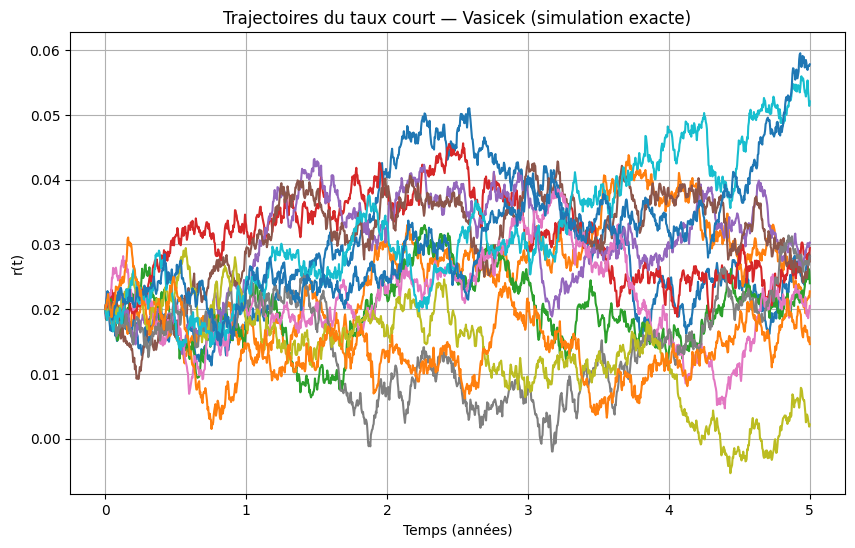

In [1]:

import numpy as np
import matplotlib.pyplot as plt

def vasicek_exact_paths(r0=0.02, k=0.5, theta=0.03, sigma=0.01, T=5.0, N=252*5, n_paths=10, seed=1):
    rng = np.random.default_rng(seed)
    dt = T / N
    r = np.full((n_paths, N+1), r0, dtype=float)
    a = np.exp(-k*dt)
    sd = sigma * np.sqrt((1 - np.exp(-2*k*dt)) / (2*k))
    for i in range(N):
        z = rng.standard_normal(n_paths)
        r[:, i+1] = theta + (r[:, i] - theta)*a + sd*z
    t = np.linspace(0, T, N+1)
    return t, r

t, r_paths = vasicek_exact_paths(r0=0.02, k=0.6, theta=0.03, sigma=0.012, T=5.0, N=252*5, n_paths=12, seed=42)
plt.figure(figsize=(10,6))
for k_ in range(r_paths.shape[0]):
    plt.plot(t, r_paths[k_])
plt.title("Trajectoires du taux court — Vasicek (simulation exacte)")
plt.xlabel("Temps (années)")
plt.ylabel("r(t)")
plt.grid(True)
plt.show()


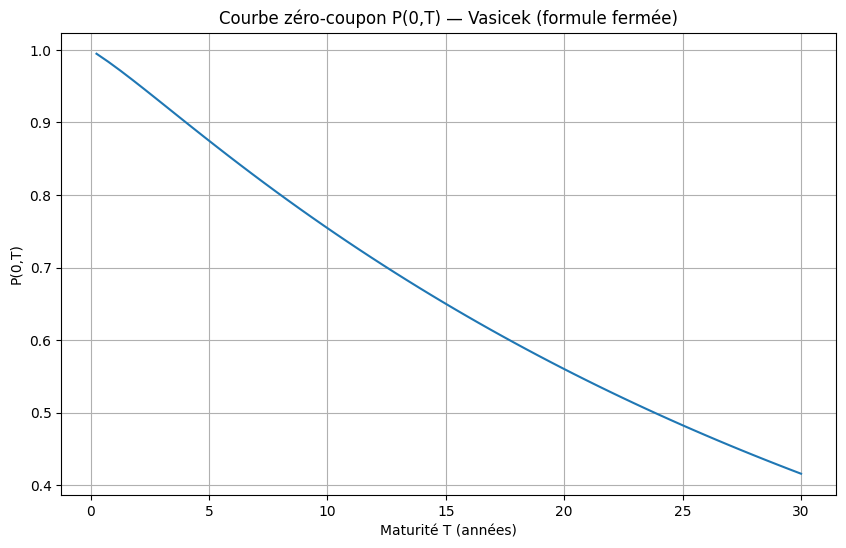

In [2]:

def vasicek_B(k, tau):
    return (1 - np.exp(-k*tau))/k

def vasicek_A(k, theta, sigma, tau):
    B = vasicek_B(k, tau)
    term1 = (theta - sigma**2/(2*k**2))*(B - tau)
    term2 = (sigma**2/(4*k))*B**2
    return np.exp(term1 - term2)

def vasicek_P0T(r0, k, theta, sigma, T_grid):
    T_grid = np.asarray(T_grid)
    tau = T_grid
    A = vasicek_A(k, theta, sigma, tau)
    B = vasicek_B(k, tau)
    return A * np.exp(-B * r0)

T_grid = np.linspace(0.25, 30.0, 60)
P_curve = vasicek_P0T(r0=0.02, k=0.6, theta=0.03, sigma=0.012, T_grid=T_grid)

plt.figure(figsize=(10,6))
plt.plot(T_grid, P_curve)
plt.title("Courbe zéro-coupon P(0,T) — Vasicek (formule fermée)")
plt.xlabel("Maturité T (années)")
plt.ylabel("P(0,T)")
plt.grid(True)
plt.show()



## 3) Modèle **CIR** : propriétés et simulation

**EDS** : $dr_t = k(\theta - r_t)\,dt + \sigma \sqrt{r_t}\, dW_t$  
- **Positivité** si **condition de Feller** : $2k\theta \ge \sigma^2$.
- Volatilité dépendante du niveau de taux → volatilité **plus forte** quand $r_t$ est élevé.

**Simulation** :  
- **Exacte** : $r_{t+\Delta t}$ suit une loi **chi-deux non centrale** (implémentation non triviale).  
- **Euler “full truncation”** (pratique) : tronquer $r_t$ dans le terme $\sqrt{r_t}$ pour éviter des imaginaires et forcer la positivité.

**Formule des ZC** (fermée) : $P(t,T)=A(t,T)e^{-B(t,T)r_t}$ avec $\tau=T-t$,
- $\gamma = \sqrt{k^2 + 2\sigma^2}$
- $B(\tau) = \dfrac{2\,(e^{\gamma \tau}-1)}{(\gamma+k)\,(e^{\gamma \tau}-1) + 2\gamma}$
- $A(\tau) = \left[\dfrac{2\gamma\, e^{(k+\gamma)\tau/2}}{(\gamma + k)(e^{\gamma \tau}-1) + 2\gamma}\right]^{\frac{2k\theta}{\sigma^2}}$


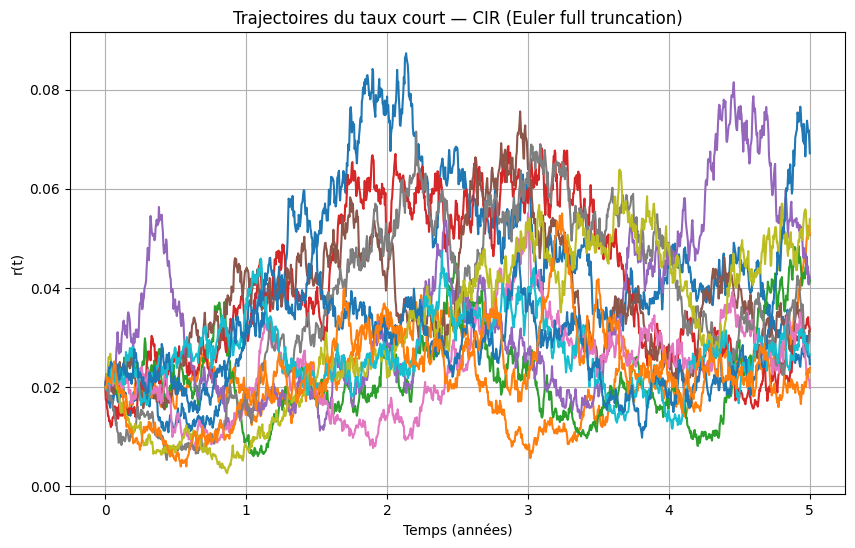

In [3]:

import numpy as np
import matplotlib.pyplot as plt

def cir_full_truncation_paths(r0=0.02, k=0.6, theta=0.03, sigma=0.10, T=5.0, N=252*5, n_paths=10, seed=1):
    rng = np.random.default_rng(seed)
    dt = T / N
    r = np.full((n_paths, N+1), r0, dtype=float)
    for i in range(N):
        z = rng.standard_normal(n_paths)
        r_sqrt = np.sqrt(np.maximum(r[:, i], 0.0))
        r_next = r[:, i] + k*(theta - np.maximum(r[:, i], 0.0))*dt + sigma*r_sqrt*np.sqrt(dt)*z
        r[:, i+1] = np.maximum(r_next, 0.0)
    t = np.linspace(0, T, N+1)
    return t, r

t_cir, r_cir = cir_full_truncation_paths(r0=0.02, k=1.0, theta=0.03, sigma=0.12, T=5.0, N=252*5, n_paths=12, seed=2)

plt.figure(figsize=(10,6))
for k_ in range(r_cir.shape[0]):
    plt.plot(t_cir, r_cir[k_])
plt.title("Trajectoires du taux court — CIR (Euler full truncation)")
plt.xlabel("Temps (années)"); plt.ylabel("r(t)"); plt.grid(True); plt.show()


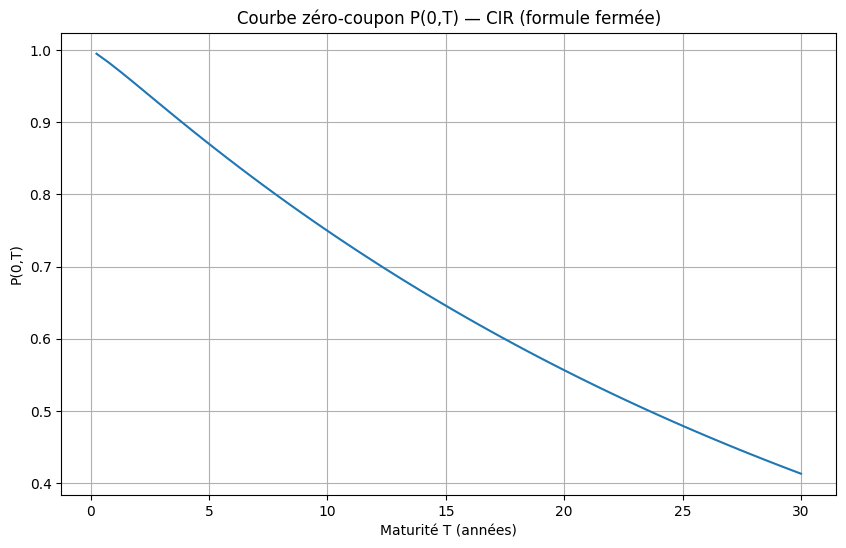

In [4]:

def cir_B(k, sigma, tau):
    gamma = np.sqrt(k**2 + 2*sigma**2)
    num = 2*(np.exp(gamma*tau) - 1)
    den = (gamma + k)*(np.exp(gamma*tau) - 1) + 2*gamma
    return num / den

def cir_A(k, theta, sigma, tau):
    gamma = np.sqrt(k**2 + 2*sigma**2)
    num = 2*gamma*np.exp((k+gamma)*tau/2)
    den = (gamma + k)*(np.exp(gamma*tau) - 1) + 2*gamma
    power = 2*k*theta/sigma**2
    return (num/den)**power

def cir_P0T(r0, k, theta, sigma, T_grid):
    T_grid = np.asarray(T_grid)
    tau = T_grid
    A = cir_A(k, theta, sigma, tau)
    B = cir_B(k, sigma, tau)
    return A * np.exp(-B * r0)

T_grid = np.linspace(0.25, 30.0, 60)
P_curve_cir = cir_P0T(r0=0.02, k=1.0, theta=0.03, sigma=0.12, T_grid=T_grid)

plt.figure(figsize=(10,6))
plt.plot(T_grid, P_curve_cir)
plt.title("Courbe zéro-coupon P(0,T) — CIR (formule fermée)")
plt.xlabel("Maturité T (années)"); plt.ylabel("P(0,T)"); plt.grid(True); plt.show()



## 4) Effet des paramètres $(k,\theta,\sigma)$ — intuition pratique

- **$k$ (vitesse)** : plus grand $\Rightarrow$ réversion plus rapide vers $\theta$, autocorrélation plus faible.  
- **$\theta$ (moyenne LT)** : niveau d’attraction ; augmente $\Rightarrow$ courbe tend à baisser (discounts plus forts).  
- **$\sigma$ (volatilité)** : éventail des trajectoires ; impact sur convexité des prix d'obligations (effet non-linéaire).

On compare quelques variations sous Vasicek.


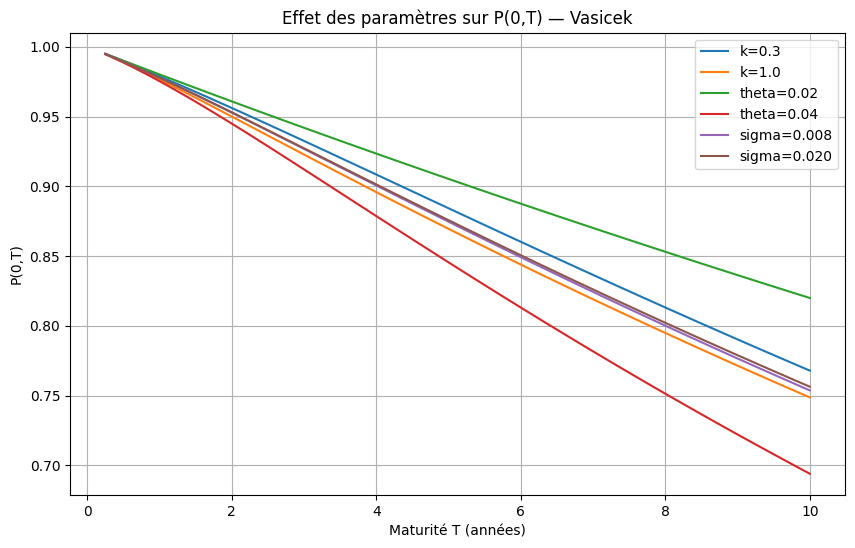

In [5]:

def demo_vasicek_param_sweep():
    import matplotlib.pyplot as plt
    T=10.0
    grid = np.linspace(0.25, T, 80)
    cases = [
        ("k=0.3", 0.3, 0.03, 0.012),
        ("k=1.0", 1.0, 0.03, 0.012),
        ("theta=0.02", 0.6, 0.02, 0.012),
        ("theta=0.04", 0.6, 0.04, 0.012),
        ("sigma=0.008", 0.6, 0.03, 0.008),
        ("sigma=0.020", 0.6, 0.03, 0.020),
    ]
    plt.figure(figsize=(10,6))
    for label, k_, th_, sig_ in cases:
        P = vasicek_P0T(r0=0.02, k=k_, theta=th_, sigma=sig_, T_grid=grid)
        plt.plot(grid, P, label=label)
    plt.title("Effet des paramètres sur P(0,T) — Vasicek")
    plt.xlabel("Maturité T (années)"); plt.ylabel("P(0,T)"); plt.grid(True)
    plt.legend()
    plt.show()

demo_vasicek_param_sweep()



## 5) **Mini-calibrage** jouet (Vasicek) sur données synthétiques

Discrétisation AR(1) induite par la solution exacte :
$$
r_{t+\Delta} = \alpha + \phi\,r_t + \varepsilon,\quad \phi=e^{-k\Delta},\quad \alpha=\theta(1-\phi),\quad \varepsilon\sim\mathcal{N}\!\big(0,\ \sigma^2 \tfrac{1-e^{-2k\Delta}}{2k}\big).
$$

On peut estimer $(\alpha,\phi)$ par **moindres carrés** et en déduire $(k,\theta)$ :
$$
\hat{k} = -\frac{1}{\Delta}\ln \hat{\phi},\qquad \hat{\theta} = \frac{\hat{\alpha}}{1-\hat{\phi}}.
$$
Puis estimer $\sigma$ via la variance résiduelle et la relation ci-dessus.


In [6]:

import numpy as np

def vasicek_calibrate_ols(r, dt):
    x = r[:-1]
    y = r[1:]
    X = np.vstack([np.ones_like(x), x]).T
    beta = np.linalg.lstsq(X, y, rcond=None)[0]
    alpha_hat, phi_hat = beta[0], beta[1]
    k_hat = -np.log(phi_hat)/dt
    theta_hat = alpha_hat/(1 - phi_hat)
    resid = y - (alpha_hat + phi_hat*x)
    s2 = np.var(resid, ddof=2)
    sigma_hat = np.sqrt( s2 * 2*k_hat / (1 - np.exp(-2*k_hat*dt)) )
    return k_hat, theta_hat, sigma_hat, alpha_hat, phi_hat

dt = 1/252
_, r_syn = vasicek_exact_paths(r0=0.02, k=0.7, theta=0.03, sigma=0.012, T=3.0, N=int(3/dt), n_paths=1, seed=0)
r_series = r_syn[0]
k_hat, theta_hat, sigma_hat, alpha_hat, phi_hat = vasicek_calibrate_ols(r_series, dt)
k_hat, theta_hat, sigma_hat


(np.float64(4.530640883704322),
 np.float64(0.022691892285226552),
 np.float64(0.012042651890932286))


## 6) Prix ZC : comparaison **Formule fermée** vs **Monte Carlo** (Vasicek)

On vérifie que :
$$
P(0,T) \approx \frac{1}{M}\sum_{m=1}^M \exp\!\Big(-\sum_{i=0}^{N-1} r_{i\Delta t}\,\Delta t\Big),
$$
avec une simulation **exacte** de $r_t$ et intégration **rectangle gauche** du taux.


In [7]:

def zc_price_mc_vasicek(r0, k, theta, sigma, T, Nsteps=252*5, M=20000, seed=123):
    rng = np.random.default_rng(seed)
    dt = T/Nsteps
    a = np.exp(-k*dt)
    sd = sigma * np.sqrt((1 - np.exp(-2*k*dt)) / (2*k))
    r = np.full((M, Nsteps+1), r0, dtype=float)
    z = rng.standard_normal((M, Nsteps))
    for i in range(Nsteps):
        r[:, i+1] = theta + (r[:, i] - theta)*a + sd*z[:, i]
    integ = np.sum(r[:, :-1], axis=1) * dt
    disc = np.exp(-integ)
    return disc.mean()

r0, k, theta, sigma = 0.02, 0.6, 0.03, 0.012
T = 5.0
P_mc = zc_price_mc_vasicek(r0, k, theta, sigma, T, Nsteps=252*5, M=10000, seed=7)

A = vasicek_A(k, theta, sigma, T)
B = vasicek_B(k, T)
P_closed = A * np.exp(-B * r0)

P_mc, P_closed


(np.float64(0.8749607336419951), np.float64(0.8749134257211482))


## 7) Exercices pratiques

1. **Calibration “marché” jouet** : À partir d’une courbe de ZC cible $P^{mkt}(0,T_i)$, ajuster $(k,\theta,\sigma,r_0)$ de Vasicek pour **minimiser** $\sum_i \big(P^{mod}(0,T_i)-P^{mkt}(0,T_i)\big)^2$.

2. **CIR — contrôle de positivité** : Implémenter la **discrétisation exacte** de CIR (loi $\chi^2$ non centrale) ou utiliser un schéma de **Quadratic-Exponential (QE)**. Comparer avec l’Euler full truncation.

3. **Sensibilités** : Calculer $\partial P/\partial r_0$ et $\partial P/\partial \sigma$ numériquement (différences finies) et interpréter.

---

## 📌 À retenir (entretien)

- **Vasicek** : OU mean-reverting, **schéma exact**, ZC **fermées** avec  
  $B(\tau)=\frac{1-e^{-k\tau}}{k}$ et  
  $A(\tau)=\exp\!\Big((\theta-\tfrac{\sigma^2}{2k^2})(B-\tau)-\tfrac{\sigma^2}{4k}B^2\Big)$.
- **CIR** : volatilité $\propto \sqrt{r}$, **positivité** si $2k\theta\ge\sigma^2$, ZC fermées basées sur $\gamma=\sqrt{k^2+2\sigma^2}$.
- **Simulation** : Vasicek exact ; pour CIR, éviter Euler simple, préférer **full truncation** ou schémas exacts/QE.
